### 📄 TRABALHO FINAL DA DISCIPLINA

**Professor:** Romuere Rodrigues Velosos e Silva

**Equipe:**

1. Iago Roberto

2. Francinaldo Barbosa

3. Cristina de Moura

### **ETAPA 0:** Importação de bibliotecas e carregamento dos dados


In [103]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, cohen_kappa_score, balanced_accuracy_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

def moldura(texto: str):
    largura = len(texto) + 4
    print("+" + "-" * (largura - 2) + "+")
    print("| " + texto.center(largura - 4) + " |")
    print("+" + "-" * (largura - 2) + "+")

def add_linha(texto: str, largura_total: int = 90):
    texto = texto.strip()
    if len(texto) + 6 >= largura_total:
        largura_total = len(texto) + 10 

    largura_lados = (largura_total - len(texto) - 4) // 2
    linha = "-" * largura_lados

    if (largura_total - len(texto) - 4) % 2 != 0:
        print(f"\n# {linha} {texto} {linha}- #\n")
    else:
        print(f"\n# {linha} {texto} {linha} #\n")

color_knn = '#5c6bc0'    # Índigo suave
color_nb = '#81c784'     # Verde suave
custom_colors = [color_knn, color_nb]

sns.set(style='whitegrid', palette=custom_colors, font_scale=1.1)

moldura("Carregando dataset")

ds = fetch_ucirepo(id=519) 
X_raw = ds.data.features.copy()
y_raw = ds.data.targets.copy()

if isinstance(y_raw, pd.DataFrame): y_raw = y_raw.iloc[:, 0]
y_raw = np.asarray(y_raw).ravel()

print(f"\nX shape: {X_raw.shape}, Y shape: {y_raw.shape}")
print("\nDistribuição alvo:")
print(pd.Series(y_raw).value_counts())

print("\n")
moldura("Visão Geral do Dataset")

add_linha("Primeiras 5 linhas")
display(X_raw.head())

add_linha("Informações de X")
X_raw.info()

add_linha("Estatísticas descritivas de X")
display(X_raw.describe())


+--------------------+
| Carregando dataset |
+--------------------+

X shape: (299, 12), Y shape: (299,)

Distribuição alvo:
0    203
1     96
Name: count, dtype: int64


+------------------------+
| Visão Geral do Dataset |
+------------------------+

# ---------------------------------- Primeiras 5 linhas ---------------------------------- #



,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0000,0,582,0,20,1,265000.0000,1.9000,130,1,0,4
1,55.0000,0,7861,0,38,0,263358.0300,1.1000,136,1,0,6
2,65.0000,0,146,0,20,0,162000.0000,1.3000,129,1,1,7
3,50.0000,1,111,0,20,0,210000.0000,1.9000,137,1,0,7
4,65.0000,1,160,1,20,0,327000.0000,2.7000,116,0,0,8



# ----------------------------------- Informações de X ----------------------------------- #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
dtypes: float64(3), int64(9)
m

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
count,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000,299.0000
mean,60.8339,0.4314,581.8395,0.4181,38.0836,0.3512,263358.0293,1.3939,136.6254,0.6488,0.3211,130.2609
std,11.8948,0.4961,970.2879,0.4941,11.8348,0.4781,97804.2369,1.0345,4.4125,0.4781,0.4677,77.6142
min,40.0000,0.0000,23.0000,0.0000,14.0000,0.0000,25100.0000,0.5000,113.0000,0.0000,0.0000,4.0000
25%,51.0000,0.0000,116.5000,0.0000,30.0000,0.0000,212500.0000,0.9000,134.0000,0.0000,0.0000,73.0000
50%,60.0000,0.0000,250.0000,0.0000,38.0000,0.0000,262000.0000,1.1000,137.0000,1.0000,0.0000,115.0000
75%,70.0000,1.0000,582.0000,1.0000,45.0000,1.0000,303500.0000,1.4000,140.0000,1.0000,1.0000,203.0000
max,95.0000,1.0000,7861.0000,1.0000,80.0000,1.0000,850000.0000,9.4000,148.0000,1.0000,1.0000,285.0000


### **ETAPA 1:** Pré-processamento e divisão dos dados

In [104]:
X_enc = X_raw.copy()
for col in X_enc.select_dtypes(include=['object', 'category']).columns:
    X_enc[col] = LabelEncoder().fit_transform(X_enc[col].astype(str))

le = LabelEncoder()
y_enc = le.fit_transform(y_raw)

moldura("Divisão 60/20/20")

X_temp, X_test, y_temp, y_test = train_test_split(
    X_enc.values, y_enc, test_size=0.20, stratify=y_enc, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Treino: {len(y_train)} \nValidação: {len(y_val)} \nTeste: {len(y_test)}")

+------------------+
| Divisão 60/20/20 |
+------------------+
Treino: 179 
Validação: 60 
Teste: 60


### **ETAPA 1.1:** Econtrando o melhor valor para K

In [105]:
moldura("Encontrando o melhor K")

scores_by_k = []

scaler_opt = StandardScaler()
X_train_s = scaler_opt.fit_transform(X_train)
X_val_s = scaler_opt.transform(X_val)

for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_s, y_train)
    score = knn.score(X_val_s, y_val)
    scores_by_k.append({'K': k, 'Score': score})

scores_df = pd.DataFrame(scores_by_k).sort_values(by='Score', ascending=False)

print("Top 10 Ks:")
sorted_scores = sorted(scores_by_k, key=lambda x: x['Score'], reverse=True)
for item in sorted_scores[:10]:
    print(f"K: {item['K']:3.0f} | Score: {item['Score']:7.4f}")


scaler_opt = StandardScaler()
X_train_s = scaler_opt.fit_transform(X_train)
X_val_s = scaler_opt.transform(X_val)

best_k = 1
best_score = 0

for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_s, y_train)
    score = knn.score(X_val_s, y_val)
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nMelhor K encontrado: {best_k}")

+------------------------+
| Encontrando o melhor K |
+------------------------+
Top 10 Ks:
K:   5 | Score:  0.8000
K:   7 | Score:  0.7667
K:  19 | Score:  0.7667
K:   3 | Score:  0.7500
K:  21 | Score:  0.7500
K:  23 | Score:  0.7500
K:   1 | Score:  0.7333
K:   9 | Score:  0.7333
K:  11 | Score:  0.7333
K:  13 | Score:  0.7333

Melhor K encontrado: 5


### **ETAPA 3:** Aplicação dos algoritmos e o K-Fold

In [106]:
clfs = {
    'KNN': KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1),
    'Naive Bayes': GaussianNB()
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_data = []

for name, clf in clfs.items():
    for fold_i, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train)):
        X_f_tr, X_f_ts = X_train[train_idx], X_train[test_idx]
        y_f_tr, y_f_ts = y_train[train_idx], y_train[test_idx]
        
        sc = StandardScaler()
        X_f_tr_s = sc.fit_transform(X_f_tr)
        X_f_ts_s = sc.transform(X_f_ts)
        
        clf.fit(X_f_tr_s, y_f_tr)
        y_p = clf.predict(X_f_ts_s)
        
        cv_data.append({
            'Modelo': name,
            'Fold': fold_i,
            'Acurácia': accuracy_score(y_f_ts, y_p),
            'F1-Score': f1_score(y_f_ts, y_p, zero_division=0),
            'Precisão': precision_score(y_f_ts, y_p, zero_division=0),
            'Recall': recall_score(y_f_ts, y_p, zero_division=0),
            'Balanced Acc': balanced_accuracy_score(y_f_ts, y_p)
        })

df_cv = pd.DataFrame(cv_data)

test_results = []
scaler_final = StandardScaler()
X_train_final = scaler_final.fit_transform(X_train)
X_test_final = scaler_final.transform(X_test)

for name, clf in clfs.items():
    clf.fit(X_train_final, y_train)
    y_pred = clf.predict(X_test_final)
    mean_cv_acc = df_cv[df_cv['Modelo'] == name]['Acurácia'].mean()
    
    test_results.append({
        'Modelo': name,
        'Acurácia': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'Precisão': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'Acurácia Média do K-Fold': mean_cv_acc
    })

moldura("Tabela comparativa (Teste)")
df_table = pd.DataFrame(test_results)
print(df_table.set_index('Modelo').round(4).to_string())

+----------------------------+
| Tabela comparativa (Teste) |
+----------------------------+
             Acurácia  F1-Score  Precisão  Recall  Acurácia Média do K-Fold
Modelo                                                                     
KNN            0.7500    0.4444    0.7500  0.3158                    0.7208
Naive Bayes    0.7000    0.4000    0.5455  0.3158                    0.7375


### **ETAPA 4:** Gráficos

+----------+
| Gráficos |
+----------+
+--------------------------+
| Gráfico da variável alvo |
+--------------------------+


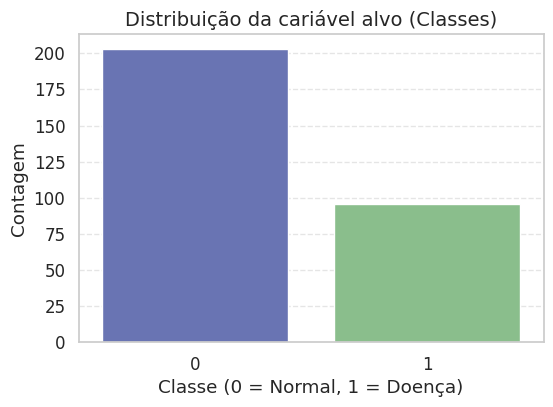

+---------------------------+
| Boxplot das métricas (CV) |
+---------------------------+


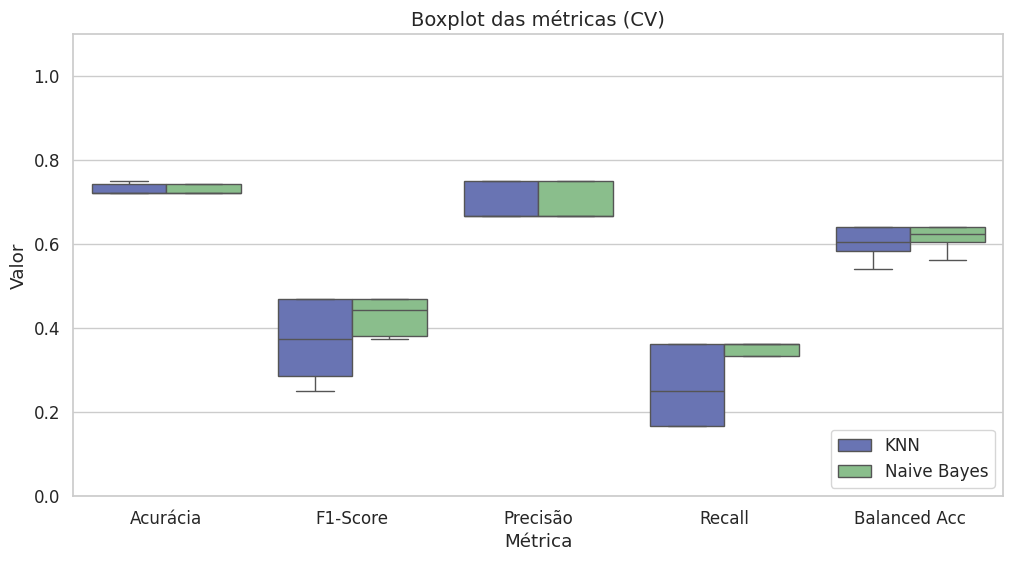

+--------------------------------------+
| Gráfico de barras com margem de erro |
+--------------------------------------+


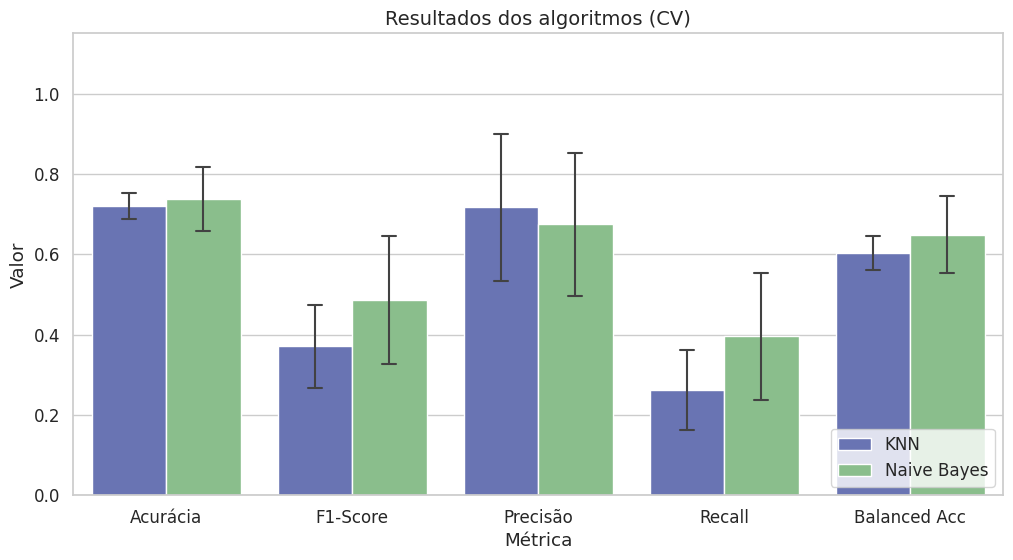

+----------------------------+
| Matrizes de confusão e ROC |
+----------------------------+


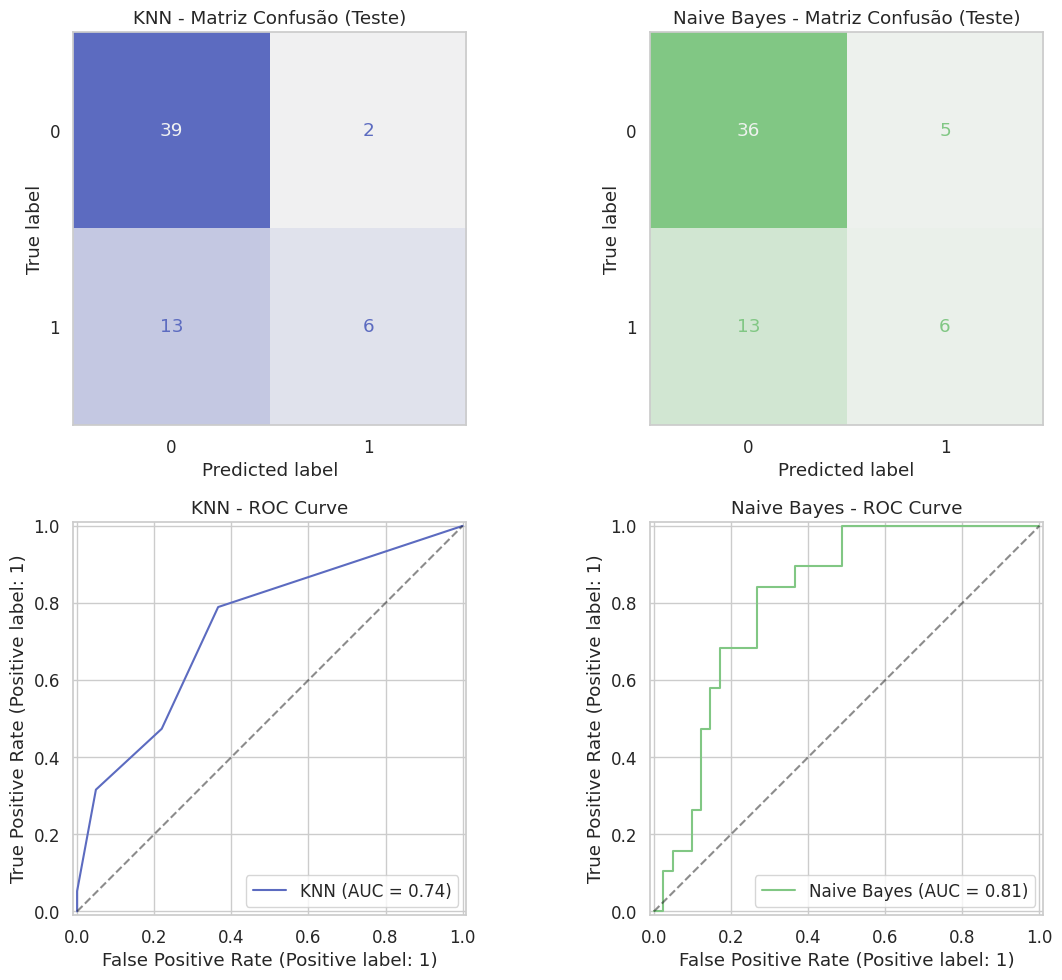

In [107]:
moldura("Gráficos")

# --- 1. GRÁFICO DA VARIÁVEL ALVO ---
moldura("Gráfico da variável alvo")
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=y_enc, palette=['#5c6bc0', '#81c784'])
plt.title("Distribuição da cariável alvo (Classes)", fontsize=14)
plt.xlabel("Classe (0 = Normal, 1 = Doença)")
plt.ylabel("Contagem")
plt.xticks(ticks=[0, 1], labels=le.inverse_transform([0, 1]))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# --- 2. BOXPLOT DAS 5 MÉTRICAS (K-FOLD) ---
moldura("Boxplot das métricas (CV)")
df_long = df_cv.melt(id_vars=['Modelo', 'Fold'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_long, x='Métrica', y='Valor', hue='Modelo', showfliers=False
)
plt.title("Boxplot das métricas (CV)", fontsize=14)
plt.ylim(0.0, 1.1)
plt.legend(loc='lower right')
plt.show()


# --- 3. GRÁFICO DE BARRAS COM MARGEM DE ERRO ---
moldura("Gráfico de barras com margem de erro")
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_long, x='Métrica', y='Valor', hue='Modelo', 
    errorbar='sd', capsize=0.15, err_kws={'linewidth': 1.5}
)
plt.title("Resultados dos algoritmos (CV)", fontsize=14)
plt.ylim(0, 1.15)
plt.legend(loc='lower right')
plt.show()


# --- 4. MATRIZES DE CONFUSÃO E ROC ---
moldura("Matrizes de confusão e ROC")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, clf) in enumerate(clfs.items()):
    clf.fit(X_train_final, y_train)
    y_pred = clf.predict(X_test_final)
    try: y_prob = clf.predict_proba(X_test_final)[:, 1]
    except: y_prob = None

    current_color = custom_colors[i]
    
    specific_cmap = sns.light_palette(current_color, as_cmap=True)

    ax_cm = axes[i]

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax_cm, cmap=specific_cmap, colorbar=False)
    ax_cm.set_title(f"{name} - Matriz Confusão (Teste)")
    ax_cm.grid(False)

    # ROC
    ax_roc = axes[i+2]
    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax_roc, name=name, color=current_color)
        ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax_roc.set_title(f"{name} - ROC Curve")
    else:
        ax_roc.text(0.5, 0.5, "N/A", ha='center')

plt.tight_layout()
plt.show()